In [ ]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt

In [ ]:
def define_discriminator(inputs = 2):
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer = 'he_uniform', input_dim = inputs))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(5, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 80        
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

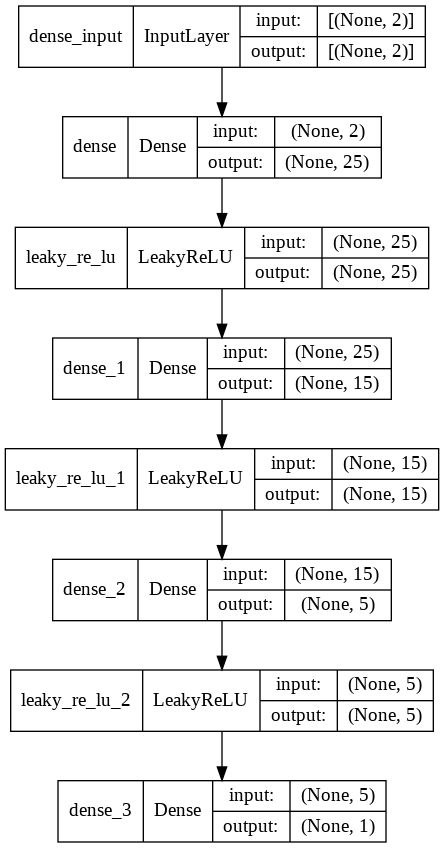

In [ ]:
discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

In [ ]:
def define_generator(latent_dim, outputs = 2):
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer= 'he_uniform', input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(outputs, activation = 'linear'))
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                150       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 15)                390       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 32        
                                                                 
Total params: 572
Trainable params: 572
Non-trainable params: 0
_________________________________________________________________


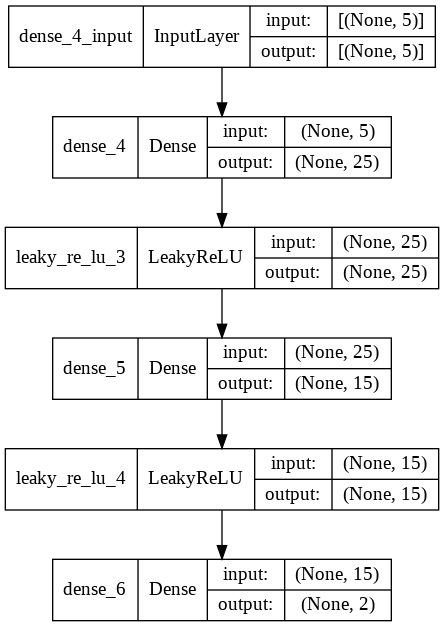

In [ ]:
latent_dim = 5
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

In [ ]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 572       
                                                                 
 sequential (Sequential)     (None, 1)                 551       
                                                                 
Total params: 1,123
Trainable params: 572
Non-trainable params: 551
_________________________________________________________________


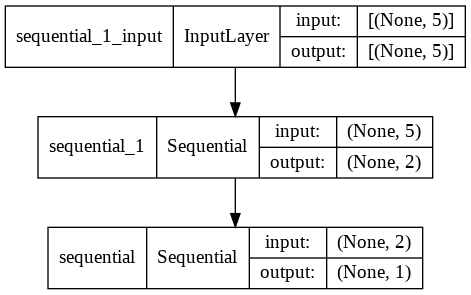

In [ ]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [ ]:
def generate_real_samples(n):
    x1 = np.random.rand(n) - 0.5
    x2 = x1**2
    x1 = x1.reshape(n, 1)
    x2 = x2.reshape(n, 1)
    X = np.hstack((x1, x2))
    y = np.ones((n, 1))
    return X,y

In [ ]:
def generate_latent_points(latent_dim, n):
    x_input = np.random.rand(latent_dim*n)
    x_input = x_input.reshape(n,latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    x = generator.predict(x_input)
    y = np.zeros((n, 1))
    return x, y

In [ ]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n = 100):
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose = 1)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 1)
    print('Epoch: ' + str(epoch) + ' Real Acc.: ' + str(acc_real) + ' Fake Acc.: '+ str(acc_fake))
    plt.scatter(x_real[:,0], x_real[:,1], color = 'red')
    plt.scatter(x_fake[:,0], x_fake[:,1], color = 'blue')
    plt.show()

In [ ]:
def train_gan(g_model,d_model,gan_model,latent_dim, num_epochs = 10000,num_eval = 2000, batch_size = 128):
    half_batch = int(batch_size/2)
  	#run epochs
    for i in range(num_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_model.train_on_batch(X_fake, y_fake)
        x_gan = generate_latent_points(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))
        gan_model.train_on_batch(x_gan, y_gan)
        if (i+1) % num_eval == 0:
            summarize_performance(i + 1, g_model, d_model, latent_dim)

In [ ]:
latent_dim = 5

In [ ]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

4/4 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.7100
Epoch: 2000 Real Acc.: 0.6000000238418579 Fake Acc.: 0.7099999785423279


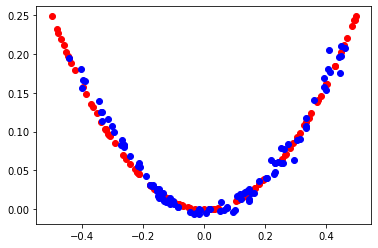

4/4 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.5400
Epoch: 4000 Real Acc.: 0.7200000286102295 Fake Acc.: 0.5400000214576721


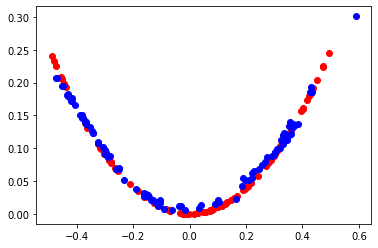

4/4 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5700
Epoch: 6000 Real Acc.: 0.7900000214576721 Fake Acc.: 0.5699999928474426


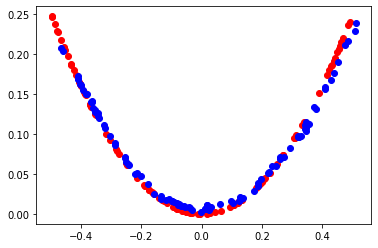

4/4 [==============================] - 0s 3ms/step - loss: 0.4942 - accuracy: 0.7700
Epoch: 8000 Real Acc.: 0.5600000023841858 Fake Acc.: 0.7699999809265137


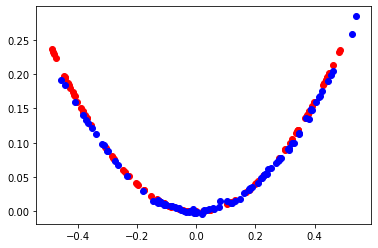

4/4 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6000
Epoch: 10000 Real Acc.: 0.9599999785423279 Fake Acc.: 0.6000000238418579


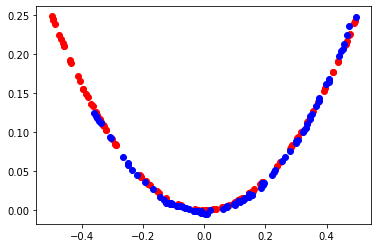

In [ ]:
train_gan(generator, discriminator, gan_model, latent_dim)